In [1]:
# Install necessary requirements
# !pip install -r requirements


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random
import numpy as np
import cv2
import joblib
import helper_module
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, DenseNet121, MobileNetV3Large, EfficientNetV2S
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, Model
from tensorflow.keras.metrics import AUC
from tensorflow.image import ssim
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity


Check if TPU is available

In [3]:
# Check if a TPU is available
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU detected and initialized.")
except ValueError:
    # No TPU found, specify GPU or CPU here
    use_gpu = True  # Set this to True to use GPU or False to use CPU
    if use_gpu and tf.config.list_physical_devices("GPU"):
        strategy = tf.distribute.MirroredStrategy()  # Use GPU
        print("Using GPU for TensorFlow computations.")
    else:
        strategy = tf.distribute.get_strategy()  # Use CPU
        print("Using CPU for TensorFlow computations.")

# Now you can define and run your TensorFlow model using the selected strategy

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Using GPU for TensorFlow computations.


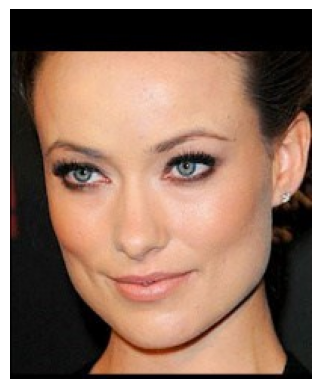

In [4]:
helper_module.show_img('dataset/train/left/abn.jpg')
train_pairing_df =helper_module.read_csv_to_df('dataset/train.csv')
test_candidates_df = helper_module.read_csv_to_df('dataset/test_candidates.csv')
archive_images_df = helper_module.read_csv_to_df('archive/votes.csv')

1.  Load Training data and augment it
2.  Load Testing data

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to [0, 1]
    rotation_range=0,      # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift image width by up to 20%
    height_shift_range=0.2, # Randomly shift image height by up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.0,         # Randomly zoom in on images by up to 20%
    horizontal_flip=False,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill mode for newly created pixels
)


Now Pair up the left and right images 
1. The  Data format will be  [Left,[Right1, Right2 ....]] In here the Right1 will be the similar image


In [6]:
def load_and_preprocess_image(image_path, target_size=(224,224), random_transform=False):
    # Open the image using Pillow (PIL)
    img = load_img(image_path, target_size=target_size)

    img = img.resize(target_size)

    img = img_to_array(img, dtype='uint8')


    if random_transform:
        img = train_datagen.random_transform(img)

    return img

def create_train_valid_dataset(random_transform, num_right_images=20):
    # Create a list to store the dataset
    dataset = []

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in train_pairing_df.iterrows():
        left_image = load_and_preprocess_image(f"dataset/train/left/{row['left']}.jpg", random_transform=random_transform)

        # Load and preprocess similar image
        similar_image = load_and_preprocess_image(f"dataset/train/right/{row['right']}.jpg", random_transform=random_transform)

        # Load and preprocess additional dissimilar images
        right_images = [similar_image] # put similar image at index 0

        for i in range(num_right_images-1):
            right_idx = random.randint(0, len(train_pairing_df) - 1)

            # Ensure the right right image is different from the similar image
            while right_idx == index:
                right_idx = random.randint(0, len(train_pairing_df) - 1)

            right_image = load_and_preprocess_image(f"dataset/train/right/{train_pairing_df.iloc[right_idx]['right']}.jpg", random_transform=random_transform)
            right_images.append(right_image)

        # Create a data entry containing the left image, list of right images, and the index of the similar image
        data_entry = [left_image, right_images]
        dataset.append(data_entry)

    return dataset

def create_train_valid_dataset_archive(random_transform, num_right_images=20):
    # Create lists to store paired left and right images
    image_pairs_with_label = []

    # Define the directory path where your images are located
    left_image_directory = 'archive/left/left/'  # Update with the correct directory path
    right_image_directory = 'archive/right/right/'  # Update with the correct directory path

    # Define the range for generating random indices
    min_idx = 1
    max_idx = 6015

    # Iterate through the rows of the CSV file and load/preprocess the images
    for index, row in archive_images_df.iterrows():
        # Generate the filename based on the index (e.g., '00000.jpg', '00001.jpg', etc.)
        image_filename = f"{index + 1:05d}.jpg"

        # Construct the full paths to the left and right images
        left_image_path = os.path.join(left_image_directory, image_filename)
        right_image_path = os.path.join(right_image_directory, image_filename)

        # Check if both image files exist
        if os.path.exists(left_image_path) and os.path.exists(right_image_path) and row['wins']>row['fails']:
            # Load and preprocess the left image
            left_image = load_and_preprocess_image(left_image_path, random_transform=random_transform)

            # Load and preprocess the right image
            right_image = load_and_preprocess_image(right_image_path, random_transform=random_transform)

            # Create a pair with left image and a list of right images
            image_pair_with_label = [left_image, [right_image]]

            # Add random dissimilar right images to the list
            for _ in range(num_right_images - 1):  # Subtract 1 to account for the similar right image
                random_idx = random.randint(min_idx, max_idx)
                while random_idx == index + 1:  # Ensure the dissimilar image is not the same as the left image
                    random_idx = random.randint(min_idx, max_idx)
                dissimilar_image_filename = f"{random_idx:05d}.jpg"
                dissimilar_image_path = os.path.join(right_image_directory, dissimilar_image_filename)
                dissimilar_image = load_and_preprocess_image(dissimilar_image_path, random_transform=random_transform)
                image_pair_with_label[1].append(dissimilar_image)

            image_pairs_with_label.append(image_pair_with_label)
        else:
            print(f"Image files not found for index {index + 1}: {left_image_path}, {right_image_path}")


    return image_pairs_with_label

def display_image_pair(image_pair):
    left_image, right_images = image_pair
    num_right_images = len(right_images)
    
    max_images_per_row = 10  # Maximum number of images to display in a single row

    num_rows = (num_right_images - 1) // max_images_per_row + 1  # Calculate the number of rows

    plt.figure(figsize=(15, 5 * num_rows))

    for i in range(num_rows):
        start_idx = i * max_images_per_row
        end_idx = min((i + 1) * max_images_per_row, num_right_images)
        
        row_right_images = right_images[start_idx:end_idx]

        plt.subplot(num_rows, max_images_per_row + 1, i * (max_images_per_row + 1) + 1)
        plt.imshow(left_image)
        plt.title("Left Image")
        plt.axis("off")

        for j, right_image in enumerate(row_right_images):
            plt.subplot(num_rows, max_images_per_row + 1, i * (max_images_per_row + 1) + j + 2)
            plt.imshow(right_image)
            plt.title(f"Right Image {start_idx + j + 1}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


Pair up images with similar and dissimilar
Show examples

Dataset not found, creating and saving...
Image files not found for index 2: archive/left/left/00002.jpg, archive/right/right/00002.jpg
Image files not found for index 47: archive/left/left/00047.jpg, archive/right/right/00047.jpg
Image files not found for index 477: archive/left/left/00477.jpg, archive/right/right/00477.jpg
Image files not found for index 630: archive/left/left/00630.jpg, archive/right/right/00630.jpg
Image files not found for index 799: archive/left/left/00799.jpg, archive/right/right/00799.jpg
Image files not found for index 843: archive/left/left/00843.jpg, archive/right/right/00843.jpg
Image files not found for index 884: archive/left/left/00884.jpg, archive/right/right/00884.jpg
Image files not found for index 920: archive/left/left/00920.jpg, archive/right/right/00920.jpg
Image files not found for index 923: archive/left/left/00923.jpg, archive/right/right/00923.jpg
Image files not found for index 966: archive/left/left/00966.jpg, archive/right/right/00966.jpg
I

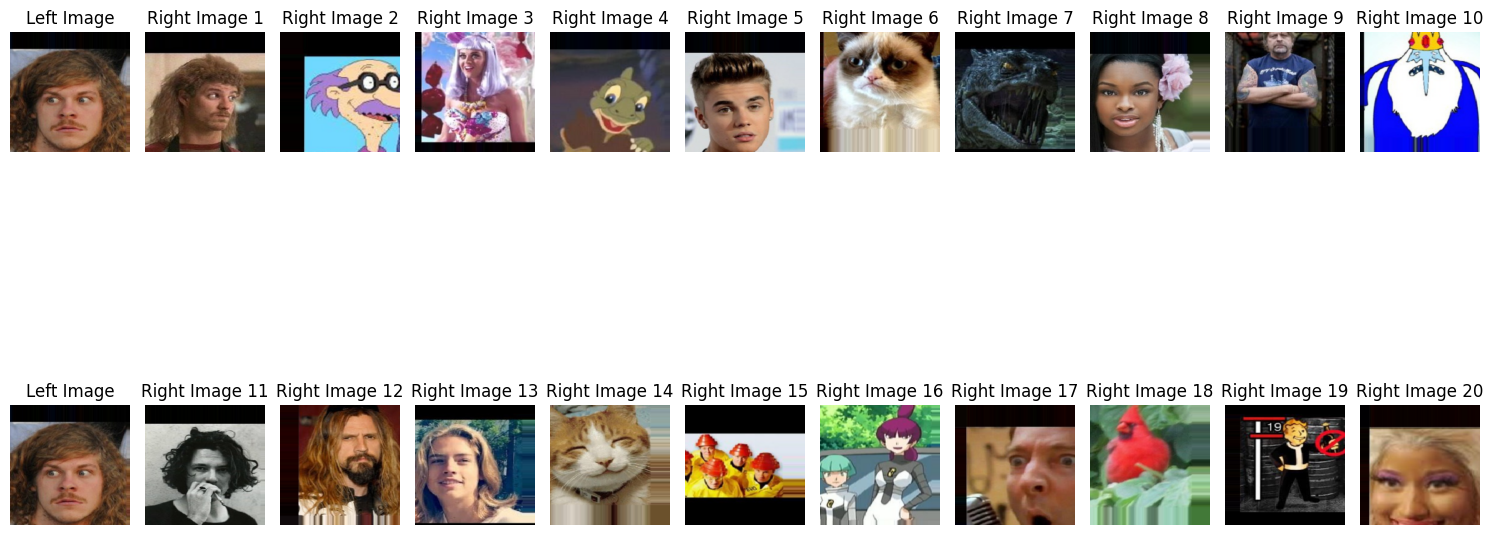

In [7]:
# Define a function to create and save the dataset if loading fails
def create_and_save_combined_dataset():
    train_valid_offical_dataset = create_train_valid_dataset(True, 20)
    train_valid_outside_dataset = create_train_valid_dataset_archive(True, 20)
    train_valid_dataset = train_valid_offical_dataset + train_valid_outside_dataset

    # Save data
    joblib.dump(train_valid_dataset, 'D:/cv_data/train_valid_dataset.joblib')

# Try to load the dataset
try:
    train_valid_dataset = joblib.load('D:/cv_data/train_valid_dataset.joblib')
    print(f"Loaded dataset size is {len(train_valid_dataset)}")
except FileNotFoundError:
    print("Dataset not found, creating and saving...")
    create_and_save_combined_dataset()
    train_valid_dataset = joblib.load('D:/cv_data/train_valid_dataset.joblib')
    print(f"Created and saved dataset size is {len(train_valid_dataset)}")

# Now you have the dataset loaded or created, and you can work with it as needed.
print(train_valid_dataset[6000][0].shape)
display_image_pair(train_valid_dataset[6000])

Now extract features using libraries. Such as local features

In [8]:
def show_local_features(detector, image):
    img = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR)

    key_points, description = detector.detectAndCompute(img, None)
    img_keypoints = cv2.drawKeypoints(img, 
                                            key_points, 
                                            img, 
                                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Draw circles.
    rgb = cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.title('detector Interest Points')
    plt.imshow(rgb); plt.show()

def image_detect_and_compute(detector, img_name):
    """Detect and compute interest points and their descriptors."""
    img = cv2.cvtColor(img_name.astype(np.uint8), cv2.COLOR_RGB2BGR)
    kp, des = detector.detectAndCompute(img, None)
    return img, kp, des
    

def draw_image_matches(detector, image_pair, distance_threshold = 0.75):
    """Draw ORB feature matches of the given two images."""

    img1, kp1, des1 = image_detect_and_compute(detector, image_pair[0])
    img2, kp2, des2 = image_detect_and_compute(detector, image_pair[1])
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < distance_threshold*n.distance:
            good.append([m])
    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    rgb = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb),plt.show()
    

Show some local feautres and match features

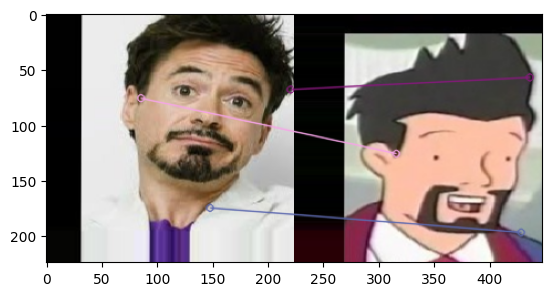

In [9]:
orb = cv2.ORB_create()
sift = cv2.SIFT_create()

# show_local_features(sift,train_valid_dataset[5][0][0])
draw_image_matches(sift, [train_valid_dataset[5][0],train_valid_dataset[5][1][0]])

Extract features from pretrained model like ResNet 

In [10]:
def extract_features(x,model):
    
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Extract features from the image
    features = model.predict(x,verbose = 0)

    return features

def visualize_feature_maps(features, number_of_feature_to_show=10, figsize=(10, 10), cmap='viridis'):
    num_features = features.shape[-1]
    num_rows = (num_features + 4) // 5  # Calculate the number of rows needed

    plt.figure(figsize=figsize)
    for i in range(number_of_feature_to_show):
        if i < num_features:
            plt.subplot(num_rows, 5, i + 1)
            feature_map = features[0, :, :, i]

            # Resize the feature map for better visualization
            resized_feature_map = cv2.resize(feature_map, (200, 200))
            plt.imshow(resized_feature_map, cmap=cmap, interpolation='nearest')
            plt.axis('off')
            plt.title(f'Feature {i + 1}')

    plt.suptitle(f'Feature Maps Visualization', fontsize=16)
    plt.tight_layout()
    plt.show()


def calculate_cosine_distance(left_image, right_image,model):
    left_image = extract_features(left_image,model)
    right_image = extract_features(right_image,model)
    return cosine_similarity([left_image.flatten()], [right_image.flatten()])[0][0]



Create model

In [11]:
def create_siamese_with_model(input_shape, base_model, unfreeze_layer_number=0, num_right_inputs=1):
   
    input_left = tf.keras.layers.Input(shape=input_shape, name="left_input")
    input_right_list = tf.keras.layers.Input(shape=(num_right_inputs,) + input_shape, name="right_input")

    
    # Split and reshape the right input images
    split_right_inputs = Lambda(lambda x: [tf.squeeze(split, axis=1) for split in tf.split(x, num_or_size_splits=num_right_inputs, axis=1)])(input_right_list)
    print("split right list shape is " + str(split_right_inputs[0].shape))
    
    embedding = create_embedding_model(input_shape, base_model,unfreeze_layer_number)

    output_left = embedding(input_left)
    output_right_list = [embedding(right_input) for right_input in split_right_inputs]

    # Calculate similarity scores (cosine similarity)
    similarity_scores = [layers.Dot(axes=-1, normalize=True)([output_left, right]) for right in output_right_list]

    # Concatenate similarity scores
    concatenated = layers.Concatenate(axis=1, name="similarity_scores")(similarity_scores)
    

    siamese_model = models.Model(inputs=[input_left, input_right_list], outputs=concatenated)

    return siamese_model

def create_embedding_model(input_shape, base_model,unfreeze_layer_number):
    for layer in base_model.layers:
        layer.trainable = False

    if unfreeze_layer_number > 0:
        for layer in base_model.layers[-unfreeze_layer_number:]:
            layer.trainable = True

    input_image = tf.keras.layers.Input(shape=input_shape)
    features = base_model(input_image)

    flatten = layers.Flatten()(features)

    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense1 = layers.Dropout(0.5)(dense1)

    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    dense2 = layers.Dropout(0.5)(dense2)
    
    output = layers.Dense(256)(dense2)

    embedding = models.Model(input_image, output, name="Embedding")

    return embedding

Define all base models

In [12]:
# Define the input shape
input_shape = (224,224, 3)

DenseNet121_model = DenseNet121(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

VGG16_model = VGG16(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

VGG19_model = VGG19(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

ResNet50_model = ResNet50(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

MobileNetV3Large_model = MobileNetV3Large(
    weights="imagenet",
    input_shape=input_shape,
    include_top=True,
)

EfficientNetV2S_model = EfficientNetV2S(
    weights="imagenet",
    input_shape=input_shape,
    include_top=False,
)

82420632/82420632 [==============================] - 19s 0us/step


To find out the performance of each different pretrained models

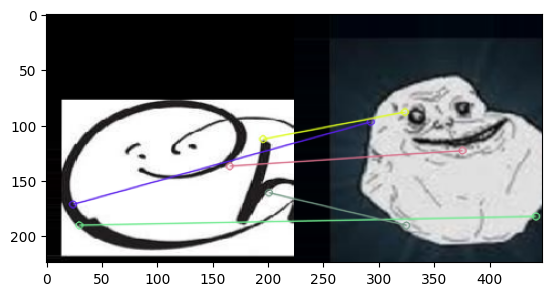

training size is 5956
VGG16 cosine score is 0.028946541249752045
VGG19 cosine score is 0.017354141920804977
DenseNet121 cosine score is 0.9999963641166687
ResNet50 cosine score is 0.05999363213777542
MobileNetV3Large cosine score is 0.10457678139209747
EfficientNetV2S cosine score is 0.4168294668197632


In [13]:
# Split the dataset into training and validation sets (e.g., 80% for training, 20% for validation)
train_pairs, valid_pairs = train_test_split(train_valid_dataset, test_size=0.2, random_state=42)

def data_generator(pair_list, batch_size=32, num_right_images=20):
    while True:
        left_images = []
        right_images = []
        labels = []

        # Shuffle the pairs for each epoch
        random.shuffle(pair_list)

        for pair in pair_list:
            left_image, right_images_list = pair[0], pair[1]

            # Create labels as a list of similarity scores (1.0 for the similar image, 0.0 for dissimilar images)
            label = [1] + [0] * (num_right_images - 1)

            left_images.append(left_image)  # Add the left image to the left_images list
            right_images.append(right_images_list[:num_right_images])
            labels.append(label)

            if len(left_images) >= batch_size:
                yield [np.array(left_images), np.array(right_images)], np.array(labels)
                left_images = []
                right_images = []
                labels = []

        # Yield the remaining data in the last batch
        if len(left_images) > 0:
            yield [np.array(left_images), np.array(right_images)], np.array(labels)

left_image = train_pairs[30][0]
right_image = train_pairs[30][1][0]

draw_image_matches(sift, [left_image,right_image])
print(f"training size is {len(train_pairs)}")
print(f"VGG16 cosine score is {calculate_cosine_distance(left_image,right_image,VGG16_model)}")
print(f"VGG19 cosine score is {calculate_cosine_distance(left_image,right_image,VGG19_model)}")
print(f"DenseNet121 cosine score is {calculate_cosine_distance(left_image,right_image,DenseNet121_model)}")
print(f"ResNet50 cosine score is {calculate_cosine_distance(left_image,right_image,ResNet50_model)}")
print(f"MobileNetV3Large cosine score is {calculate_cosine_distance(left_image,right_image,MobileNetV3Large_model)}")
print(f"EfficientNetV2S cosine score is {calculate_cosine_distance(left_image,right_image,EfficientNetV2S_model)}")

In [14]:
def custom_contrastive_loss(Y_true, D):
    margin = 1  # Margin for dissimilar pairs
    alpha = 5.0  # Weight for the most similar pair

    most_similar_score = D[:, 0]  # The first score is for the most similar image
    other_scores = D[:, 1:]  # Scores for other, dissimilar images

    # Loss for the most similar pair
    positive_pair_loss = K.square(most_similar_score)

    # Loss for the dissimilar pairs
    negative_pair_loss = K.square(K.maximum(margin - other_scores, 0))

    # Combine the two, emphasizing the most similar pair
    loss = alpha * positive_pair_loss + K.mean(negative_pair_loss, axis=-1)

    return K.mean(loss)

In [15]:
num_epochs = 10  # Adjust the number of epochs as needed
batch_size = 20  # Adjust the batch size as needed
number_of_right_images = 20
unfreeze_layer_number=0

# Example usage:
train_generator = data_generator(train_pairs,batch_size=batch_size,num_right_images=number_of_right_images)
valid_generator = data_generator(valid_pairs,batch_size=batch_size,num_right_images=number_of_right_images)

# Fetch a batch from the generator
batch = next(train_generator)
# Unpack the batch into inputs and labels
val_batch = next(valid_generator)
inputs,labels = batch
inputs_val,labels_val = val_batch
# Print the shape of the left input
print(len(batch))
print(f"Left Input shape: {inputs[0].shape}")
print(f"Right Input shape: {inputs[1].shape}")
print(f"Labels shape: {labels.shape}")


# Create the Siamese network
siamese_model = create_siamese_with_model(input_shape,base_model=DenseNet121_model,num_right_inputs=number_of_right_images,unfreeze_layer_number=unfreeze_layer_number)
# Compile the model
siamese_model.compile(loss=custom_contrastive_loss, optimizer=Adam(0.001), metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1)])
siamese_model.summary()

2
Left Input shape: (20, 224, 224, 3)
Right Input shape: (20, 20, 224, 224, 3)
Labels shape: (20, 20)
split right list shape is (None, 224, 224, 3)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 right_input (InputLayer)       [(None, 20, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                [(None, 224, 

In [16]:
try:
    history = siamese_model.fit(
        x=train_generator,
        steps_per_epoch=len(train_pairs) // batch_size,
        validation_data=valid_generator,
        validation_steps=len(valid_pairs) // batch_size,
        epochs=num_epochs,
        batch_size=batch_size
    )
except Exception as e:
    print("Error during training:", str(e))

Epoch 1/10
297/297 [==============================] - 548s 2s/step - loss: 1.0106 - top_k_categorical_accuracy: 0.0613 - val_loss: 1.7137 - val_top_k_categorical_accuracy: 0.0681
Epoch 2/10
297/297 [==============================] - 444s 1s/step - loss: 0.9123 - top_k_categorical_accuracy: 0.0593 - val_loss: 1.7599 - val_top_k_categorical_accuracy: 0.0783
Epoch 3/10
297/297 [==============================] - 443s 1s/step - loss: 0.9003 - top_k_categorical_accuracy: 0.0586 - val_loss: 1.7347 - val_top_k_categorical_accuracy: 0.0749
Epoch 4/10
297/297 [==============================] - 439s 1s/step - loss: 0.8958 - top_k_categorical_accuracy: 0.0578 - val_loss: 1.8750 - val_top_k_categorical_accuracy: 0.0735
Epoch 5/10
297/297 [==============================] - 440s 1s/step - loss: 0.8922 - top_k_categorical_accuracy: 0.0558 - val_loss: 1.8670 - val_top_k_categorical_accuracy: 0.0749
Epoch 6/10
297/297 [==============================] - 437s 1s/step - loss: 0.8917 - top_k_categorical_acc

In [17]:
import math
def show_test_case(model, test_candidates_df, row_number=10):
    for index, row in test_candidates_df.iterrows():
        if index >= row_number:
            break

        print(f"Row {index}")

        left_image = None
        right_images = []

        for column, value in row.items():
            print(f"  Column {column}: {value}")
            if column == 'left':
                left_image = load_and_preprocess_image(f"dataset/test/left/{value}.jpg")
            else:
                test_img_right = load_and_preprocess_image(f"dataset/test/right/{value}.jpg")
                right_images.append(test_img_right)

        # Convert to NumPy arrays
        left_image = np.array([left_image])
        right_images = np.array([right_images])

        # Run prediction
        try:
            similarity_scores = model.predict([left_image, right_images], verbose=0)[0]
            print("Similarity Scores:", similarity_scores)
        except Exception as e:
            print("An error occurred during prediction:", e)

        # Plot images
        num_rows = math.ceil((len(right_images[0]) + 1) / 10)
        fig, axes = plt.subplots(num_rows, 10, figsize=(20, 5 * num_rows))

        # Show left image
        if num_rows > 1:
            axes[0, 0].imshow(left_image[0])
            axes[0, 0].set_title("Left Image")
            axes[0, 0].axis('off')
        else:
            axes[0].imshow(left_image[0])
            axes[0].set_title("Left Image")
            axes[0].axis('off')

        # Show right images
        for i in range(len(right_images[0])):
            row_idx = (i + 1) // 10
            col_idx = (i + 1) % 10
            if num_rows > 1:
                axes[row_idx, col_idx].imshow(right_images[0][i])
                axes[row_idx, col_idx].set_title(f"Right {i+1}\nScore: {similarity_scores[i]:.2f}")
                axes[row_idx, col_idx].axis('off')
            else:
                axes[col_idx].imshow(right_images[0][i])
                axes[col_idx].set_title(f"Right {i+1}\nScore: {similarity_scores[i]:.2f}")
                axes[col_idx].axis('off')

        plt.show()



Row 0
  Column left: abm
  Column c0: kyr
  Column c1: qqo
  Column c2: xpv
  Column c3: tnd
  Column c4: xal
  Column c5: pvr
  Column c6: nsb
  Column c7: yzv
  Column c8: ahb
  Column c9: mlm
  Column c10: drb
  Column c11: vqu
  Column c12: vzr
  Column c13: kxe
  Column c14: mdq
  Column c15: oai
  Column c16: nmm
  Column c17: yzu
  Column c18: ihk
  Column c19: zwv
Similarity Scores: [0.53333163 0.53340113 0.5334999  0.24966538 0.36057407 0.31447175
 0.5290478  0.33933163 0.32763046 0.5335119  0.36009437 0.47412765
 0.4593025  0.5033556  0.5357456  0.45995867 0.48078778 0.52480227
 0.2708425  0.34755373]


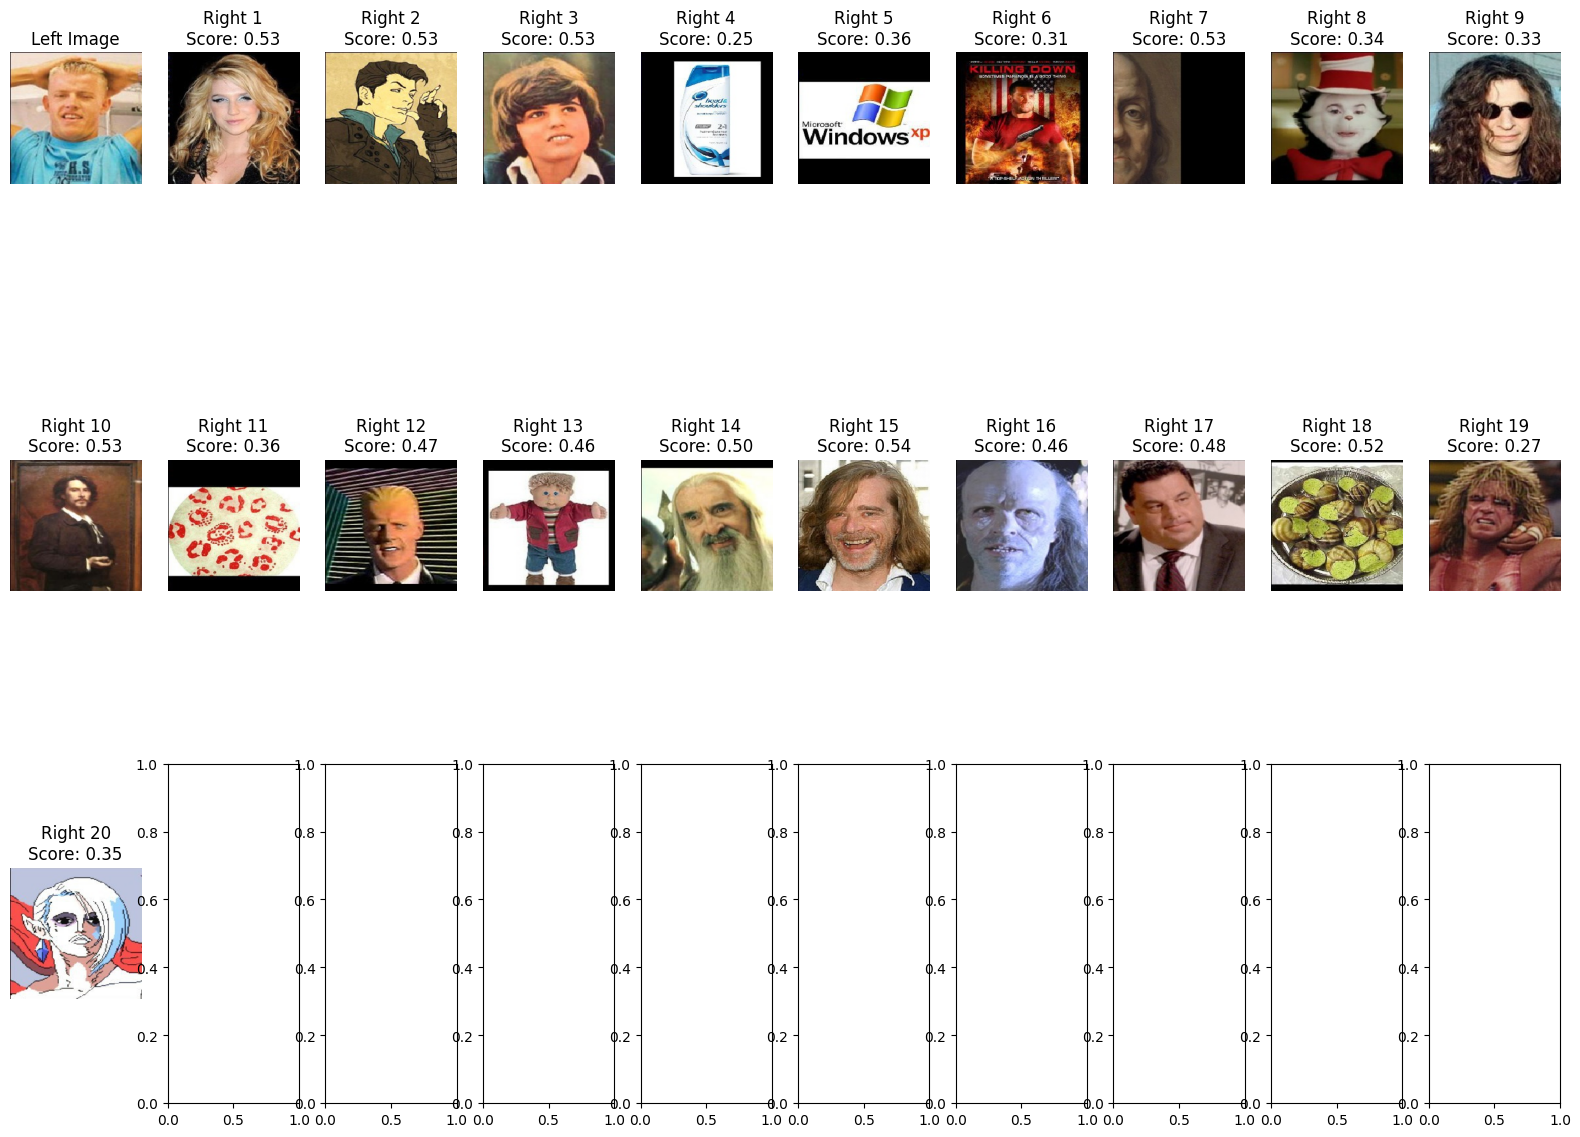

Row 1
  Column left: aci
  Column c0: jzn
  Column c1: hxw
  Column c2: iaj
  Column c3: edq
  Column c4: huu
  Column c5: huk
  Column c6: owo
  Column c7: ntd
  Column c8: uhk
  Column c9: ojv
  Column c10: mhg
  Column c11: exb
  Column c12: pny
  Column c13: kbo
  Column c14: tdb
  Column c15: sok
  Column c16: zsq
  Column c17: yfg
  Column c18: iqx
  Column c19: jnj
Similarity Scores: [0.9084649  0.87415904 0.54873055 0.4045935  0.9232456  0.99915934
 0.5783947  0.9999998  0.39740968 0.6267925  0.3351377  0.5274863
 0.6255707  0.33587235 0.42709816 0.54271877 0.43286574 0.60105944
 0.99999964 0.5388752 ]


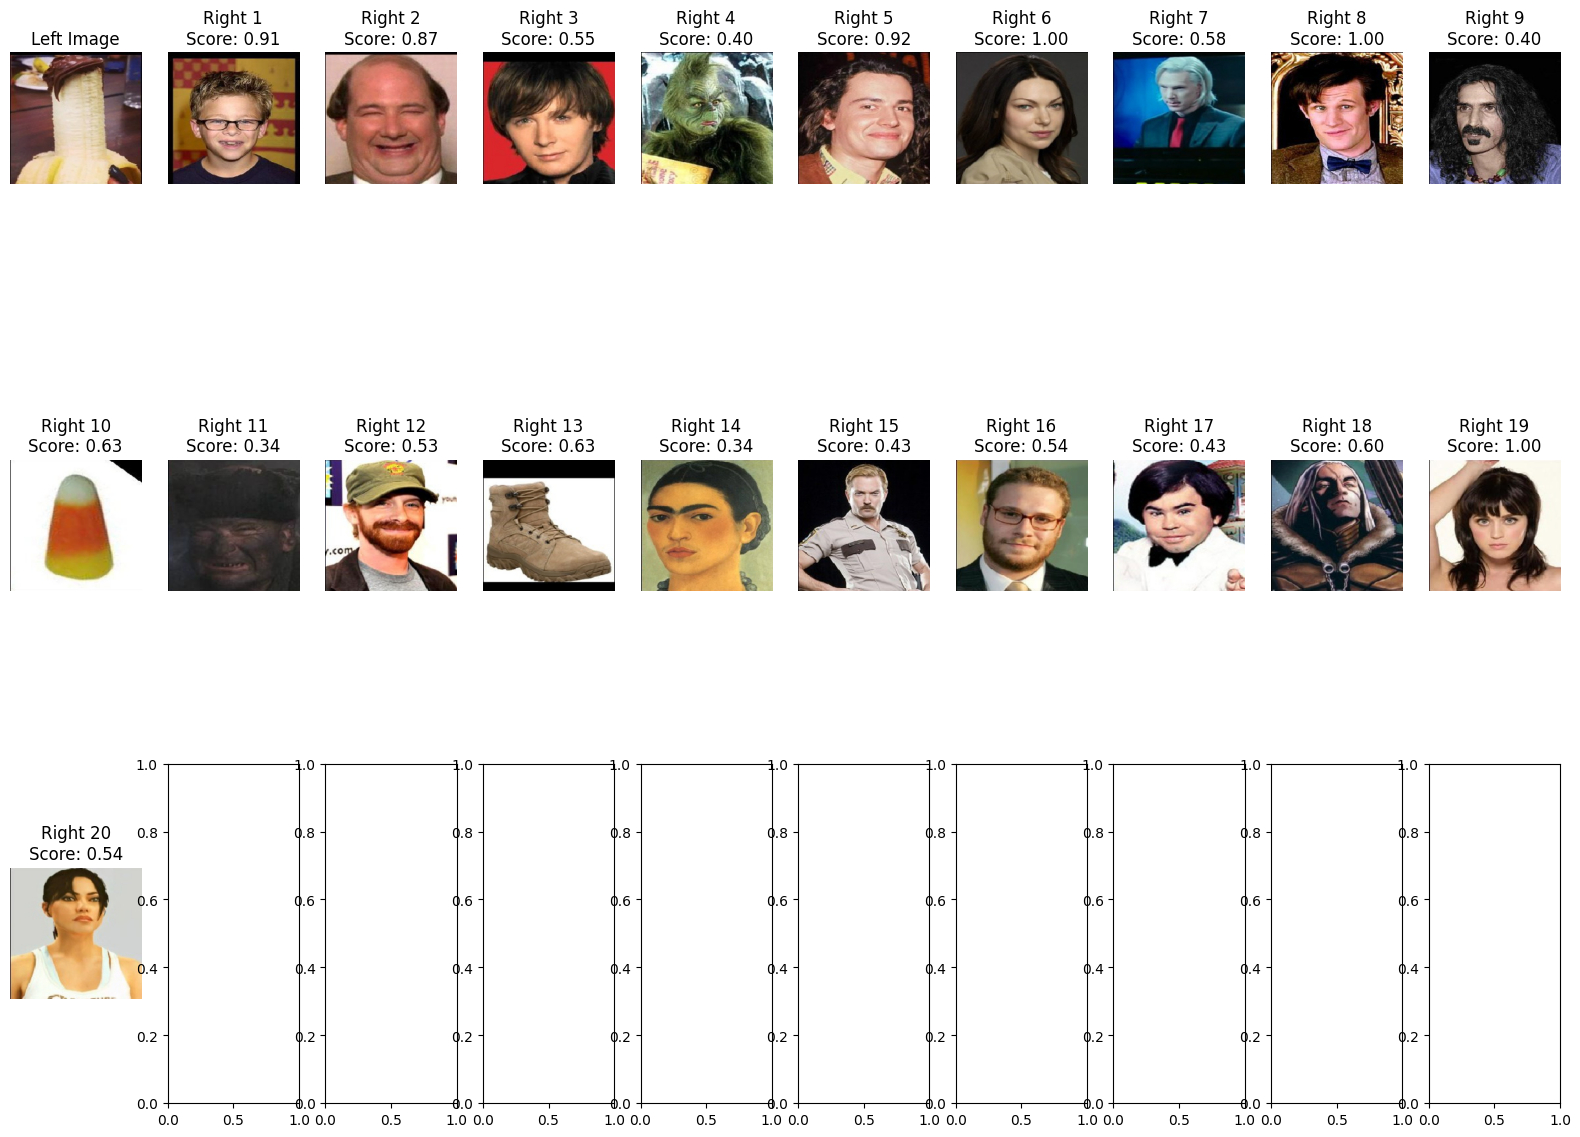

Row 2
  Column left: acn
  Column c0: ksm
  Column c1: tyj
  Column c2: hhy
  Column c3: rph
  Column c4: axt
  Column c5: dby
  Column c6: xiv
  Column c7: aoc
  Column c8: oxb
  Column c9: iyw
  Column c10: vsu
  Column c11: wrx
  Column c12: zem
  Column c13: rkq
  Column c14: vjq
  Column c15: duq
  Column c16: ncp
  Column c17: mst
  Column c18: wzd
  Column c19: gup
Similarity Scores: [0.44183218 0.961624   0.43484807 0.4685288  0.55942154 0.4324452
 0.3247593  0.7712676  0.50635374 0.7217432  0.44115233 0.7384066
 0.7713295  0.6093792  0.5404876  0.53777856 0.6756698  0.6742532
 0.60871685 0.78223336]


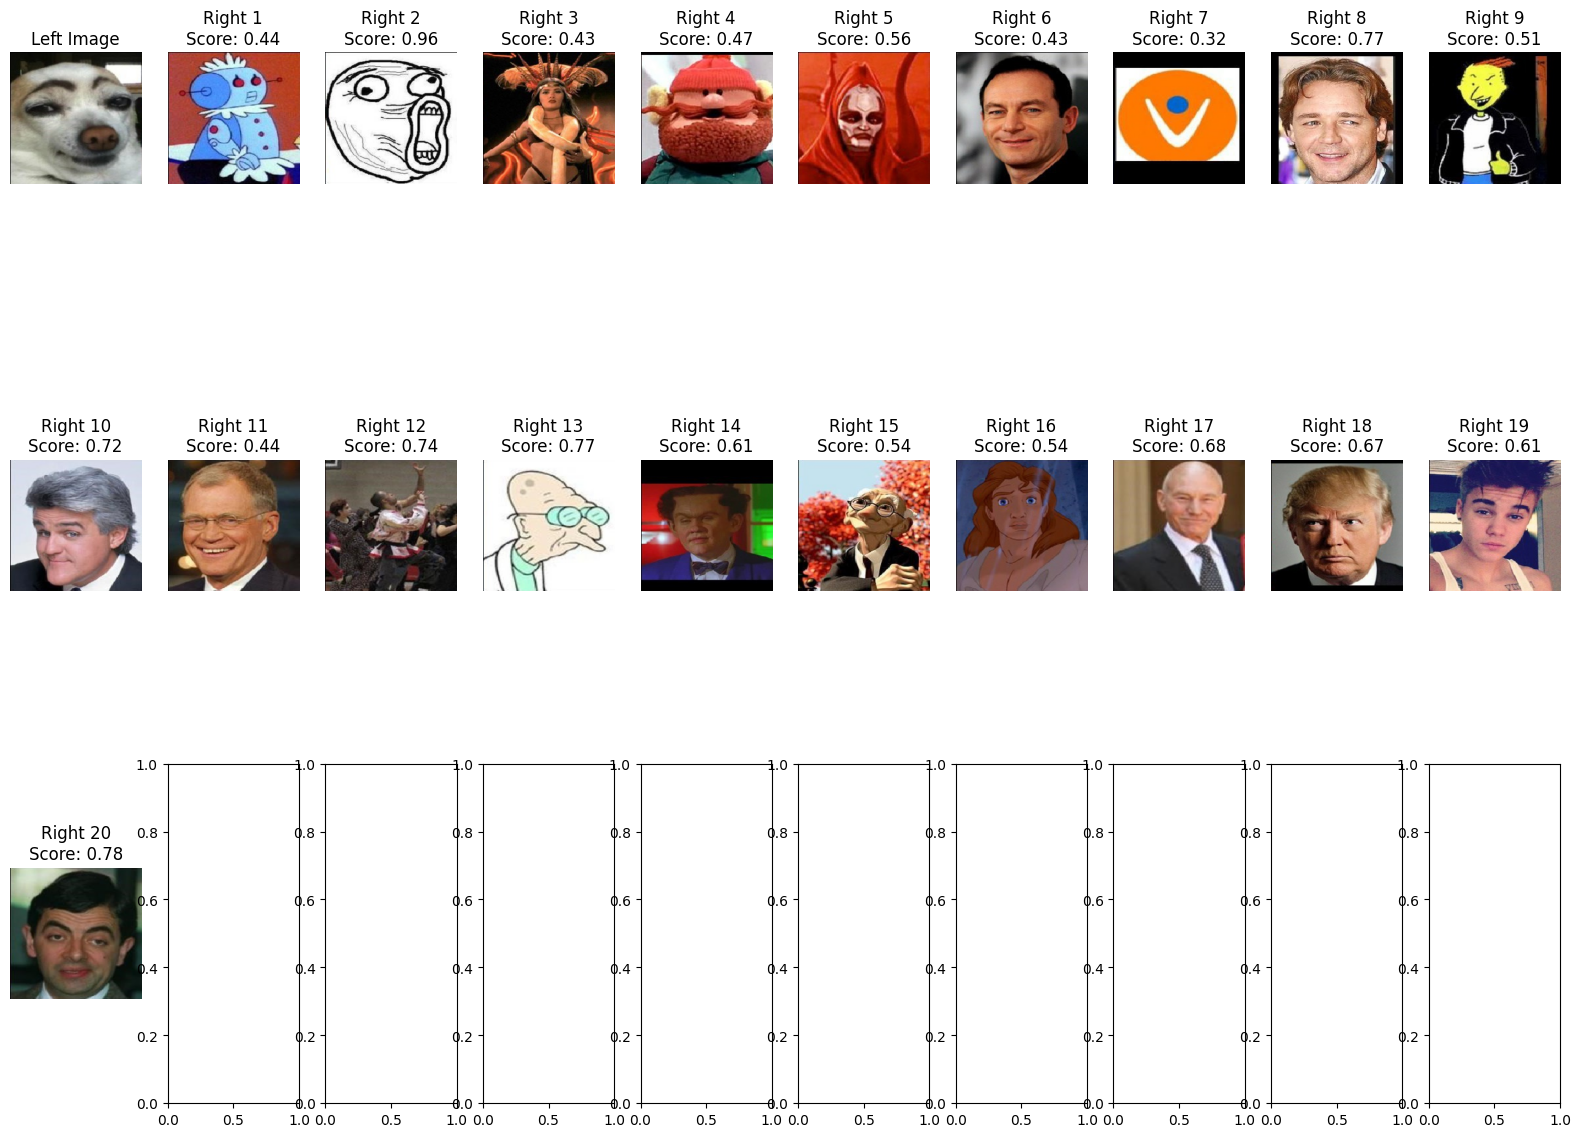

Row 3
  Column left: aco
  Column c0: tft
  Column c1: bxn
  Column c2: vkl
  Column c3: mdq
  Column c4: iqb
  Column c5: uev
  Column c6: mjn
  Column c7: ccy
  Column c8: nje
  Column c9: jsj
  Column c10: flo
  Column c11: ltz
  Column c12: sjz
  Column c13: ind
  Column c14: fbw
  Column c15: ahy
  Column c16: vwe
  Column c17: cog
  Column c18: xcj
  Column c19: boz
Similarity Scores: [0.43427664 0.5568441  0.4595042  0.46572196 0.51219404 0.4748102
 0.3435413  0.4736771  0.46917242 0.57523584 0.5862708  0.37579617
 0.57012856 0.48726577 0.46085694 0.47327316 0.3759929  0.37287477
 0.4677435  0.4787714 ]


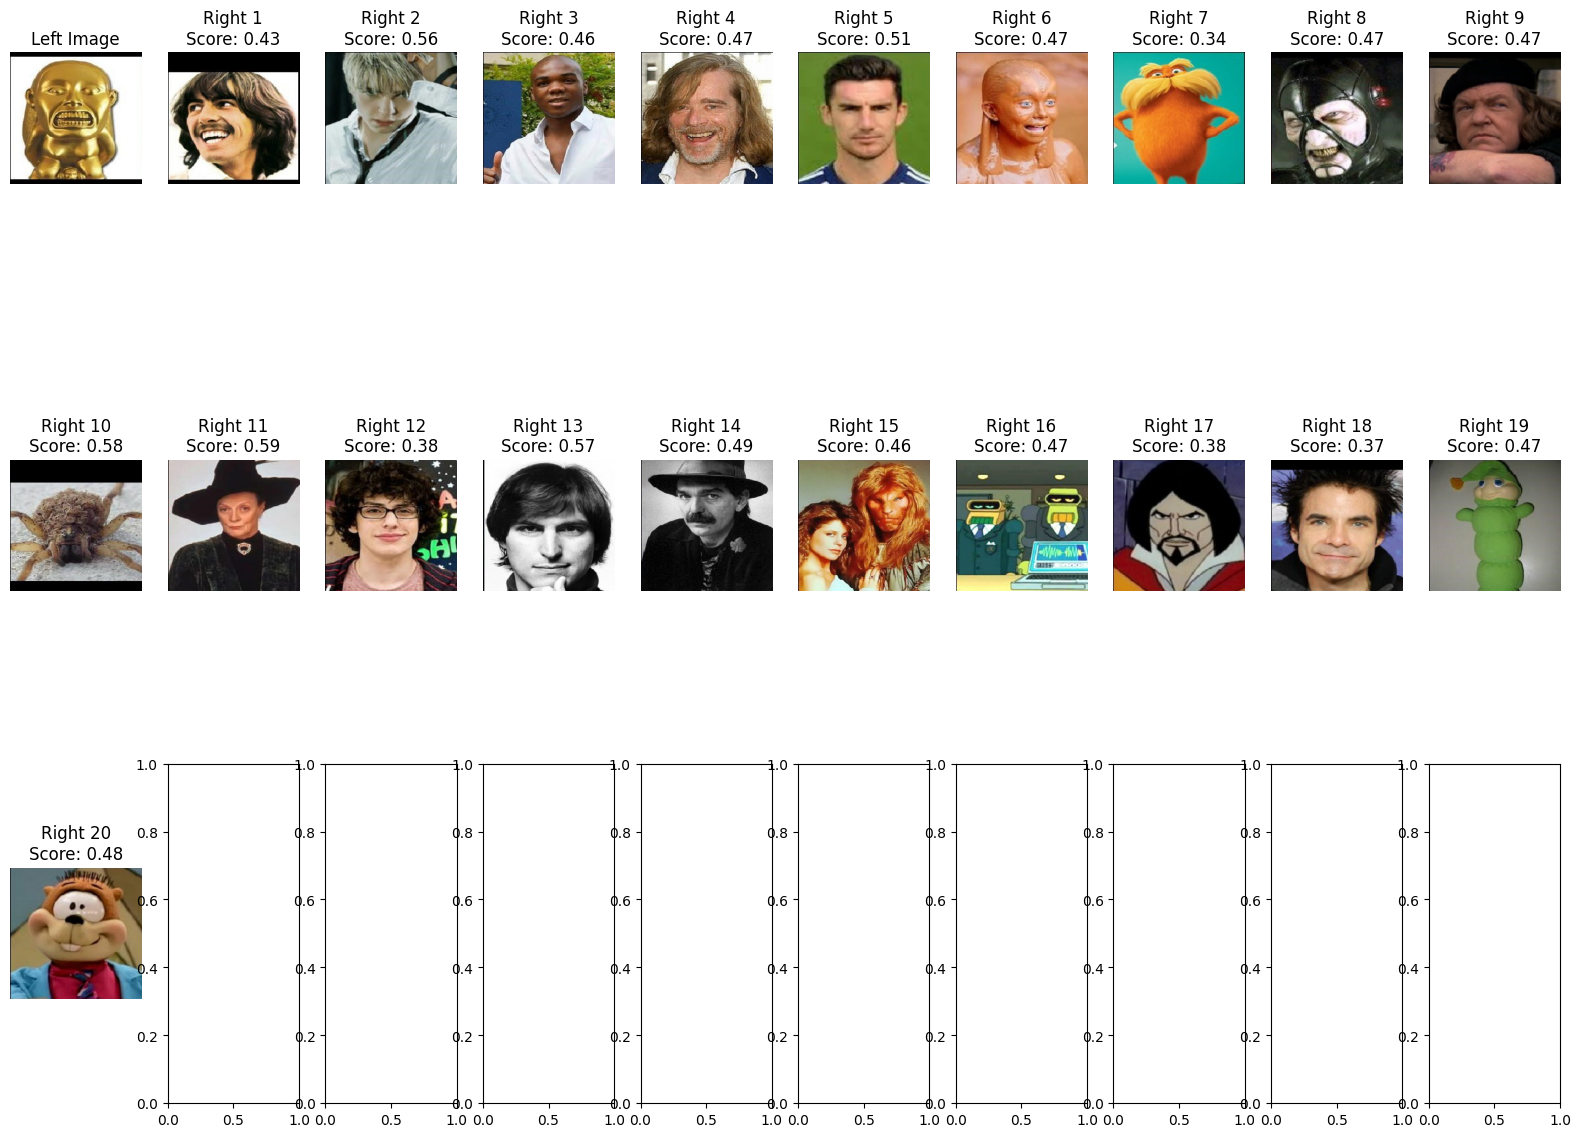

Row 4
  Column left: acu
  Column c0: apn
  Column c1: zip
  Column c2: cxx
  Column c3: cwh
  Column c4: wbu
  Column c5: azy
  Column c6: qoe
  Column c7: wnd
  Column c8: xoo
  Column c9: oxh
  Column c10: zwq
  Column c11: rqi
  Column c12: rei
  Column c13: poj
  Column c14: gos
  Column c15: hif
  Column c16: ami
  Column c17: fhc
  Column c18: ift
  Column c19: xcj
Similarity Scores: [0.41826996 0.504888   0.5386623  0.6272727  0.9867648  0.6114493
 0.6241899  0.5452278  0.50698113 0.65931064 0.48075837 0.8869015
 0.54767483 0.9998201  0.4160371  0.7233739  0.9743272  0.544004
 0.5810082  0.48355526]


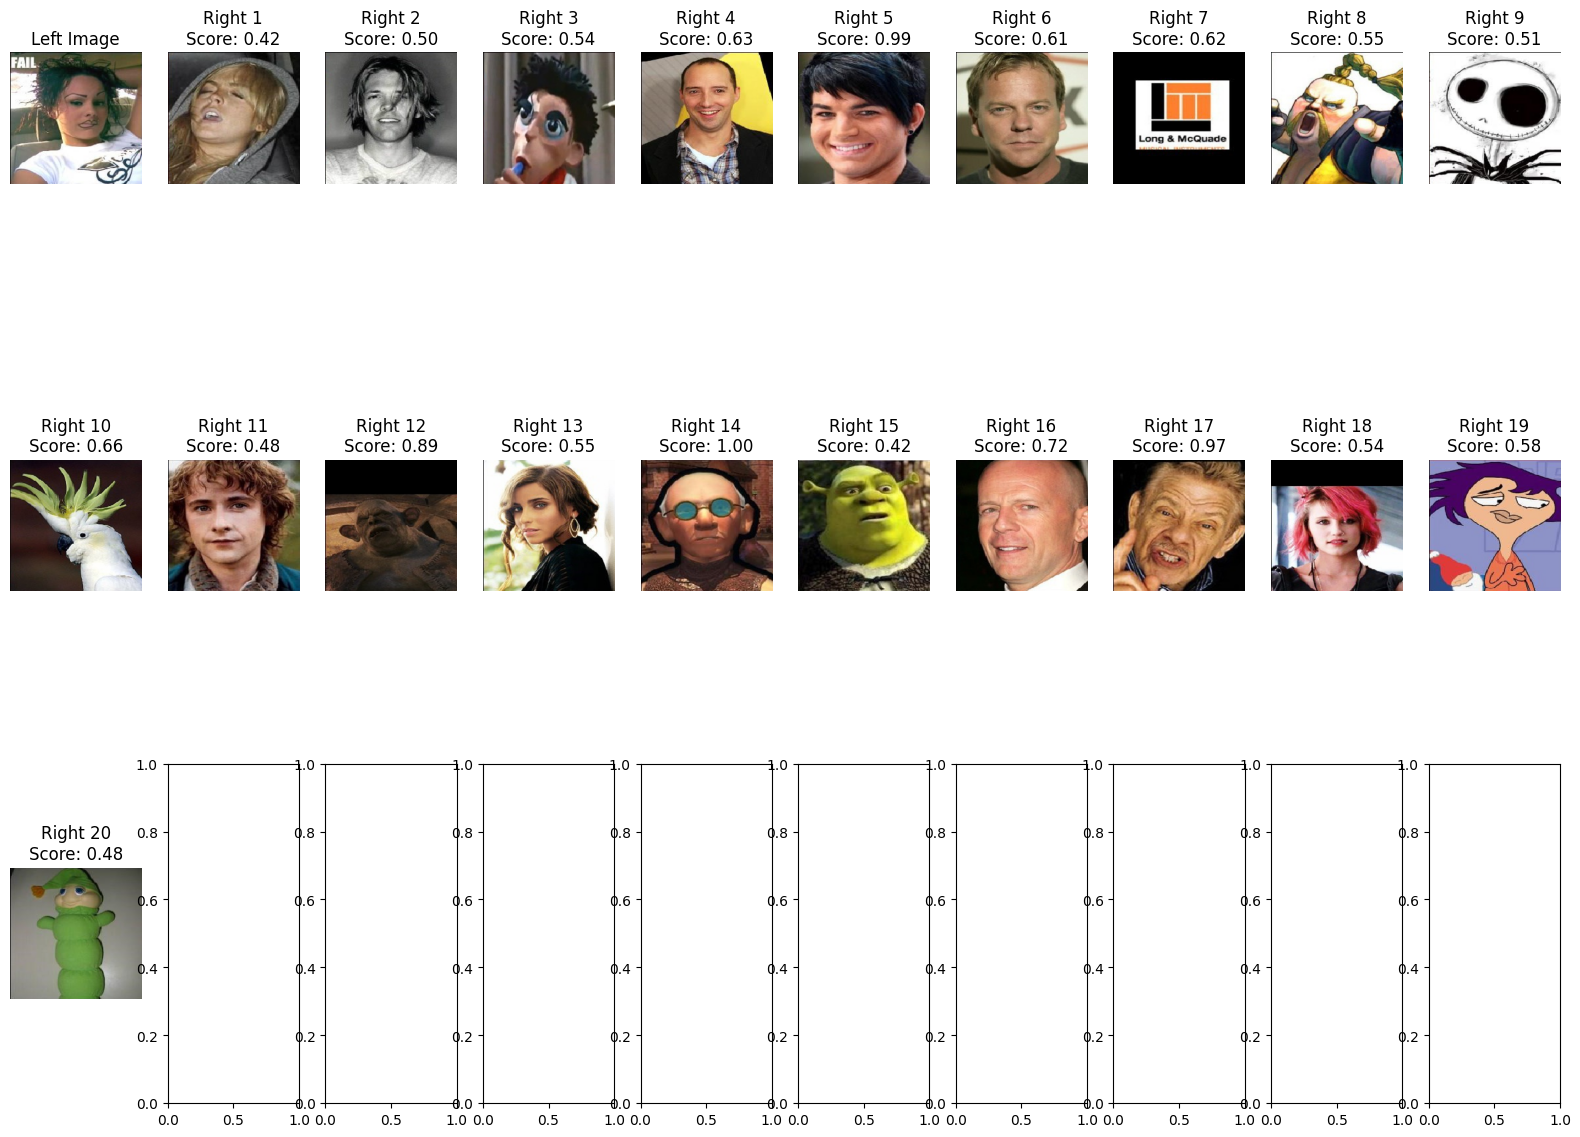

In [18]:
show_test_case(siamese_model, test_candidates_df, row_number=5)
